Полное описание алгоритма Виолы-Джонса находится в статье https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf

В данном ноутбуке считаются интегральные изображения и затем признаки Хаара.  Признаки Хаара дают точечное значение изменения яркости по осям X и Y. Всё это нужно ля детектиции лиц: общим для всех изображений будет то, что область в районе глаз темнее, чем область в районе щёк. Из этого следует, что общим признаком Хаара для лиц является два смежных прямоугольных региона, лежащих на глазах и щеках.

In [ ]:
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: negatives/neg-4059.jpg  
 extracting: negatives/neg-4060.jpg  
  inflating: negatives/neg-4061.jpg  
 extracting: negatives/neg-4062.jpg  
  inflating: negatives/neg-4064.jpg  
  inflating: negatives/neg-4065.jpg  
 extracting: negatives/neg-4066.jpg  
 extracting: negatives/neg-4067.jpg  
  inflating: negatives/neg-4068.jpg  
  inflating: negatives/neg-4069.jpg  
 extracting: negatives/neg-4070.jpg  
 extracting: negatives/neg-4071.jpg  
  inflating: negatives/neg-4072.jpg  
  inflating: negatives/neg-4073.jpg  
  inflating: negatives/neg-4074.jpg  
  inflating: negatives/neg-4075.jpg  
  inflating: negatives/neg-4076.jpg  
  inflating: negatives/neg-4077.jpg  
  inflating: negatives/neg-4078.jpg  
  inflating: negatives/neg-4079.jpg  
  inflating: negatives/neg-4080.jpg  
  inflating: negatives/neg-4081.jpg  
 extracting: negatives/neg-4082.jpg  
 extracting: negatives/neg-4083.jpg  
 extracting: negativ

# Считаем данные



In [ ]:
import numpy as np
import os

from tqdm.notebook import tqdm

from skimage import io
from skimage.transform import resize

In [ ]:
def get_all_images(starting_dir, nsamples=None):
    images = []
    stop = False
    extensions = ["pgm", "jpeg", "jpg", "png"]
    pbar = tqdm(os.walk(starting_dir), desc=f'loading from {starting_dir}, {len(images)} found')
    for dir_name, _, filenames in pbar:
        for filename in filenames:
            extension = os.path.splitext(filename)[1][1:]
            if extension in extensions:
                image = io.imread(os.path.join(dir_name, filename))
                images.append(image)
                pbar.set_description(f'loading from {starting_dir}, {len(images)} found')
                stop = nsamples and len(images) >= nsamples
            if stop:
                break
        if stop:
            pbar.set_description(f'{starting_dir} done, {len(images)} found')
            break
            
    return images

In [ ]:
positives = get_all_images('/content/positives', nsamples=1000)
n_positives = len(positives)
negatives = get_all_images('/content/negatives', nsamples=500)

loading from /content/positives, 0 found: 0it [00:00, ?it/s]

loading from /content/negatives, 0 found: 0it [00:00, ?it/s]

## Зафиксируем размер окна, на котором будет работать классификатор

In [ ]:
image_canonical_size = 24

# Препроцессинг

In [ ]:
# Вычтем из изображения среднее и поделим на стандартное отклонение
def normalize_images(images):
    result = []
    for image in tqdm(images, desc='normalizing'):
        mean, std = image.mean(), image.std()
        result.append((image - mean) / std)
    return result

## Препроцессинг изображений с лицами

* Нормируем яркость, чтобы не учитывать освещенность
* Преобразуем к 24 * 24

In [ ]:
def prepare_positives(images, size):
    result=[]
    normilized_images = normalize_images(images)
    for normilized_image in tqdm(normilized_images, desc='resizing'):
        resized_image = resize(normilized_image, (size, size), mode='constant').astype(np.float32)
        result.append(resized_image)
    return result

In [ ]:
positives_prepared = prepare_positives(positives, image_canonical_size)

normalizing:   0%|          | 0/1000 [00:00<?, ?it/s]

resizing:   0%|          | 0/1000 [00:00<?, ?it/s]

## Препроцессинг изображений без лиц

* Вырежем случайные квадраты из негативных изображений
* Нормируем яркость
* Преобразуем к 24 * 24

In [ ]:
from random import randint

def prepare_negatives(images, sample_size, size):
    norm_images = normalize_images(images)
    crops = []
    for _ in tqdm(range(0, sample_size), desc='cropping'):
        image_ind = randint(0, len(norm_images) - 1)
        image = norm_images[image_ind]
        w, h = image.shape
        max_r = min(w, h)
        r = randint(size, max_r)
        x, y = randint(0, w - max_r), randint(0, h - max_r)
        crop = image[x: x + r, y: y + r]
        crop = resize(crop, (size, size), mode='constant').astype(np.float32)
        crops.append(crop)
    return crops

In [ ]:
# Возьмем столько же негативных изображений, сколько позитивных
n_negatives = n_positives
negatives_prepared = prepare_negatives(negatives, n_negatives, image_canonical_size)

normalizing:   0%|          | 0/500 [00:00<?, ?it/s]

cropping:   0%|          | 0/1000 [00:00<?, ?it/s]

## Проверим, что данные имеют правильный формат

In [ ]:
def image_has_correct_format(image, shape=(image_canonical_size, image_canonical_size)):
    return image.shape == shape

assert(len(positives_prepared) == n_positives)
assert(all(
    [image_has_correct_format(im) for im in positives_prepared]
))

assert(len(negatives_prepared) == n_negatives)
assert(all(
    [image_has_correct_format(im) for im in negatives_prepared]
))

## Интегральное изображение

Чтобы эффективно вычислять признаки Хаара нам понадобится специальное представление изображения под названием Интегральное изображение.

Интегральное изображение I - это матрица, совпадающая по размерам с исходным изображением, в которой I(x, y) = сумме всех интенсивностей пикселей левее и выше (x, y) (включая [x, y]). Такое представление позволяет очень быстро находить сумму интенсивностей пикселей в любом подпрямоугольнике изображения (что нужно для вычисления признаков Хаара).

In [ ]:
class IntegralImage:
    def __init__(self, image):
        # numpy.cumsum два раза, чтобы получить двумерную кумулятивную сумму
        self.integral_image = np.cumsum(np.cumsum(image,axis=1),axis=0)
    
    def sum(self, x1, y1, x2, y2):
        '''
        Сумма подмассива
        
        На входе:
            x1, y1 -- координаты левого нижнего угла прямоугольника запроса
            x2, y2 -- координаты верхнего правого угла прямоугольника запроса
            
        На выходе:
            Сумма подмассива [x1..x2, y1..y2]
        '''
        assert(x1 <= x2)
        assert(y1 <= y2)
        b1 = self.integral_image[x1 - 1, y1 - 1] if x1 and y1 else 0 
        b2 = self.integral_image[x2, y1 - 1] if y1 else 0
        b3 = self.integral_image[x1 - 1, y2] if x1 else 0
        b4 = self.integral_image[x2, y2] 
        return b4 - b2 - b3 + b1 

## Протестируем

In [ ]:
test_image = np.asarray([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

test_integral_image = IntegralImage(test_image)
assert(test_integral_image.sum(0, 0, 2, 2) == sum(range(0,10)))
assert(test_integral_image.sum(0, 0, 0, 0) == 1)
assert(test_integral_image.sum(0, 0, 2, 0) == 12)
assert(test_integral_image.sum(0, 1, 1, 2) == 16)

## Подготовим интегральные изображения

In [ ]:
integral_positives = [IntegralImage(im) for im in positives_prepared]
integral_negatives = [IntegralImage(im) for im in negatives_prepared]

## Признаки Хаара

В оригинальной работе использовались признаки следующего вида:

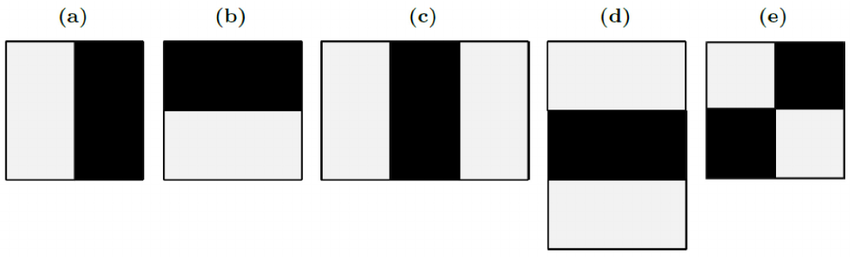

Значение признака = s1 - s2, где s1 = сумма интенсивностей в светлой области, s2 = сумма интенсивностей в темной области
Не обязательно использовать все эти признаки, но рекомендуется попробовать.

Признак задается координатами левого верхнего угла, шириной и высотой окна. Считаем, что ось x идет сверху вниз, а ось y -- справа-налево. w -- это размер окна по оси x, h -- по оси y.

### Пример реализации признака (a)

In [ ]:
class HaarFeatureVerticalTwoSegments():
    def __init__(self, x, y, w, h):
        assert(h % 2 == 0)
        assert(x >= 0)
        assert(y >= 0)
        assert(w >= 2)
        assert(h >= 2)
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        
    def compute_value(self, integral_image):
        s1 = integral_image.sum(self.x, self.y, self.x + self.w - 1, self.y + self.h // 2 - 1)
        s2 = integral_image.sum(self.x, self.y + self.h // 2, self.x + self.w - 1, self.y + self.h - 1)
        return s1 - s2

In [ ]:
test_image = np.asarray([
    [1,1,2,2],
    [1,1,2,2],
    [1,1,2,2]
])

test_feature = HaarFeatureVerticalTwoSegments(0, 0, 3, 4)
assert(test_feature.compute_value(IntegralImage(test_image)) == 6 * 1 - 6 * 2)

### Пример реализации признака (b)

In [ ]:
# признак (b)
class HaarFeatureHorizontalTwoSegments():
    
    def __init__(self, x, y, w, h):
        assert(w % 2 == 0)
        assert(x >= 0)
        assert(y >= 0)
        assert(w >= 2)
        assert(h >= 2)
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        
    def compute_value(self, integral_image):
        #TODO
        s2 = integral_image.sum(self.x, self.y, self.x + self.w // 2- 1, self.y + self.h - 1)
        s1 = integral_image.sum(self.x + self.w // 2, self.y, self.x + self.w - 1, self.y + self.h - 1)
        return s1 - s2

In [ ]:
test_image = np.asarray([
    [1,1,1,1],
    [1,1,1,1],
    [2,2,2,2],
    [2,2,2,2]
])


test_feature = HaarFeatureHorizontalTwoSegments(0, 0, 4, 4)
assert(test_feature.compute_value(IntegralImage(test_image)) == 8 * 2 - 8 * 1)

### Пример реализации признака (c)

In [ ]:
# признак (c)
class HaarFeatureVerticalThreeSegments():
    
    def __init__(self, x, y, w, h):
        assert(h % 3 == 0)
        assert(x >= 0)
        assert(y >= 0)
        assert(w >= 2)
        assert(h >= 3)
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        
    def compute_value(self, integral_image):
        #TODO
        s1 = integral_image.sum(self.x, self.y, self.x + self.w - 1, self.y + self.h // 3 - 1)
        s2 = integral_image.sum(self.x, self.y + self.h // 3, self.x + self.w - 1, self.y + self.h // 3 + self.h // 3 - 1)
        s3 = integral_image.sum(self.x, self.y + self.h // 3 + self.h // 3, self.x + self.w - 1, self.y + self.h - 1)
  
        return s1 - s2 + s3

In [ ]:
test_image = np.asarray([
    [1,1,3,3,1,1],
    [1,1,3,3,1,1],
    [1,1,3,3,1,1]
])

test_feature = HaarFeatureVerticalThreeSegments(0, 0, 3, 6)
assert(test_feature.compute_value(IntegralImage(test_image)) == 6 * 2 - 6 * 3)

### Пример реализации признака (d)

In [ ]:
# признак (d)
class HaarFeatureHorizontalThreeSegments():
    def __init__(self, x, y, w, h):
        assert(w % 3 == 0)
        assert(x >= 0)
        assert(y >= 0)
        assert(w >= 3)
        assert(h >= 2)
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        
    def compute_value(self, integral_image):
        #TODO
        s1 = integral_image.sum(self.x, self.y, self.x + self.w // 3 - 1, self.y + self.h  - 1)
        s2 = integral_image.sum(self.x + self.w // 3, self.y , self.x + self.w // 3 + self.w // 3 - 1, self.y + self.h - 1)
        s3 = integral_image.sum(self.x + self.w // 3 + self.w // 3, self.y , self.x + self.w - 1, self.y + self.h - 1)
        return s1 - s2 + s3

In [ ]:
test_image = np.asarray([
    [1,1,1],
    [1,1,1],
    [3,3,3],
    [3,3,3],
    [1,1,1],
    [1,1,1],
])

test_feature = HaarFeatureHorizontalThreeSegments(0, 0, 6, 3)
assert(test_feature.compute_value(IntegralImage(test_image)) == 6 * 2 - 6 * 3)

### Пример реализации признака (e)

In [ ]:
# признак (e)
class HaarFeatureFourSegments():
    def __init__(self, x, y, w, h):
        assert(w % 2 == 0)
        assert(h % 2 == 0)
        assert(x >= 0)
        assert(y >= 0)
        assert(w >= 2)
        assert(h >= 2)
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        
    def compute_value(self, integral_image):
        #TODO
        s2 = integral_image.sum(self.x, self.y, self.x + self.w // 2 - 1, self.y + self.h // 2 - 1)
        s3 = integral_image.sum(self.x + self.w // 2, self.y + self.h // 2, self.x + self.w  - 1, self.y + self.h - 1)
        s1 = integral_image.sum(self.x + self.w // 2, self.y , self.x + self.w  - 1, self.y + self.h //2  - 1)
        s4 = integral_image.sum(self.x, self.y + self.h // 2, self.x + self.w // 2 - 1, self.y + self.h - 1)
        return s2 - s1 - s4 + s3

In [ ]:
test_image = np.asarray([
    [1,1,0,0],
    [1,1,1,1],
    [0,0,1,1],
    [0,0,1,1]
])

test_feature = HaarFeatureFourSegments(0, 0, 4, 4)
assert(test_feature.compute_value(IntegralImage(test_image)) == 4 * 2 - 2)

## Сохраним все возможные признаки

Теперь необходимо сгенерировать все возможные признаки. Для изображение 24 * 24 их получится очень много (около 150000). Чтобы сократить время вычислений, рекомендуется брать не все признаки, а некоторое подмножество. Например, можно рассматривать окна с некоторым шагом по x, y, т.к. соседние признаки все равно сильно скоррелированы. Также можно рассматривать окна не всех размеров, а тоже выбирать их с некоторым шагом. В зависимости от возможностей компьютера, выберите шаги. 10-50 тысяч признаков должно хватить для классификатора разумной точности.

In [ ]:
features_to_use = [HaarFeatureVerticalTwoSegments, 
                   HaarFeatureVerticalThreeSegments, 
                   HaarFeatureHorizontalTwoSegments,
                   HaarFeatureHorizontalThreeSegments,
                   HaarFeatureFourSegments]
# шаги по x,y,w,h
x_stride = 2
y_stride = 2
w_stride = 2
h_stride = 2

all_features = []
for x in range(0, image_canonical_size, x_stride):
    for y in range(0, image_canonical_size, y_stride):
        for w in range(2, image_canonical_size - x + 1, w_stride):
            for h in range(2, image_canonical_size - y + 1, h_stride):
                for feature_type in features_to_use:
                    try:
                        feature = feature_type(x, y, w, h)
                        all_features.append(feature)
                    except:
                        continue
print(f"Всего признаков: {len(all_features)}")         

Всего признаков: 21684


## Вычислим все признаки на всех изображениях

In [ ]:
def compute_features_for_image(integral_image, features):
    result = np.zeros(len(features))
    for ind, feature in enumerate(features):
        result[ind] = feature.compute_value(integral_image)
    return result

def compute_features(integral_images, features):
    result = np.zeros((len(integral_images), len(features)))
    for ind, integral_image in tqdm(enumerate(integral_images)):
        result[ind] = compute_features_for_image(integral_image, features)
    return result

In [ ]:
positive_features = compute_features(integral_positives, all_features)
negative_features = compute_features(integral_negatives, all_features)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Сохраним прогресс

In [ ]:
import _pickle as pickle

with open('positive_data.pkl', 'wb') as f:
    pickle.dump(positive_features, f, 2)

with open('negative_data.pkl', 'wb') as f:
    pickle.dump(negative_features, f, 2)